# Introduction
Car accidents are dangerous, and many people die each year, approximately 1.35 million people according to the Association for Safe International Road Travel (ASIRT) [1]. 

Using a large dataset and machine learning, it should be possible to predict the severity of car accidents, which when deployed could help determine measures from policy makers to make road travel safer (and push more people to public transport). 

# Data
The City of Seattle has collected data on road incidents over a long period of time, and contains almost 200,000 datapoints, including a measure of severity. From this, several features are selected to predict the severity. 

Due to the format of the dataset, many of the features are information that is impossible to know before the accident happens. For instance, an accident containing many cars is often severe, but we cannot know how many cars will be involved before it has happened. As such, this could be another prediction target, but cannot be used as a feature for a deployed algorithm, with features we know. 

As such, the following features were selected: 
- Place of accidents, as intsersections might be more severe than just a tailend incident.
- Road contition, since wheter weather makes it slippery, or roads in need of repair.
- Light condition, since low visibility impacts the ability to mitigate the severity
- Wheather, probably correlated with road condition, but still could be useful
- Indicent Time, which will be used for feature engineering time of day and prevalence of accidents during months

Most of these are categorical variables, which sadly makes deployment harder since it has to use some type of decider to classify the light condition and so on. A more useful index would be a sensor measurement of light, but this is not available yet, and this model could be transfered into such a setting. See below for some summaries and looks into the data.  

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1]:
import nbconvert

In [2]:
df = pd.read_csv("Data-Collisions.csv")
df.head()

/Users/leocarlsson/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [3]:
df.describe()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,INTKEY,SEVERITYCODE.1,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,SDOT_COLCODE,SDOTCOLNUM,SEGLANEKEY,CROSSWALKKEY
count,194673.000000,189339.000000,189339.000000,194673.000000,194673.000000,194673.000000,65070.000000,194673.000000,194673.000000,194673.000000,194673.000000,194673.000000,194673.000000,1.149360e+05,194673.000000,1.946730e+05
mean,1.298901,-122.330518,47.619543,108479.364930,141091.456350,141298.811381,37558.450576,1.298901,2.444427,0.037139,0.028391,1.920780,13.867768,7.972521e+06,269.401114,9.782452e+03
std,0.457778,0.029976,0.056157,62649.722558,86634.402737,86986.542110,51745.990273,0.457778,1.345929,0.198150,0.167413,0.631047,6.868755,2.553533e+06,3315.776055,7.226926e+04
min,1.000000,-122.419091,47.495573,1.000000,1001.000000,1001.000000,23807.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.007024e+06,0.000000,0.000000e+00
25%,1.000000,-122.348673,47.575956,54267.000000,70383.000000,70383.000000,28667.000000,1.000000,2.000000,0.000000,0.000000,2.000000,11.000000,6.040015e+06,0.000000,0.000000e+00
50%,1.000000,-122.330224,47.615369,106912.000000,123363.000000,123363.000000,29973.000000,1.000000,2.000000,0.000000,0.000000,2.000000,13.000000,8.023022e+06,0.000000,0.000000e+00
75%,2.000000,-122.311937,47.663664,162272.000000,203319.000000,203459.000000,33973.000000,2.000000,3.000000,0.000000,0.000000,2.000000,14.000000,1.015501e+07,0.000000,0.000000e+00
max,2.000000,-122.238949,47.734142,219547.000000,331454.000000,332954.000000,757580.000000,2.000000,81.000000,6.000000,2.000000,12.000000,69.000000,1.307202e+07,525241.000000,5.239700e+06


[Text(0, 0.5, 'Severity'),
 Text(0.5, 0, 'Weather'),
 Text(0.5, 1.0, 'Average severity in differet weather conditions')]

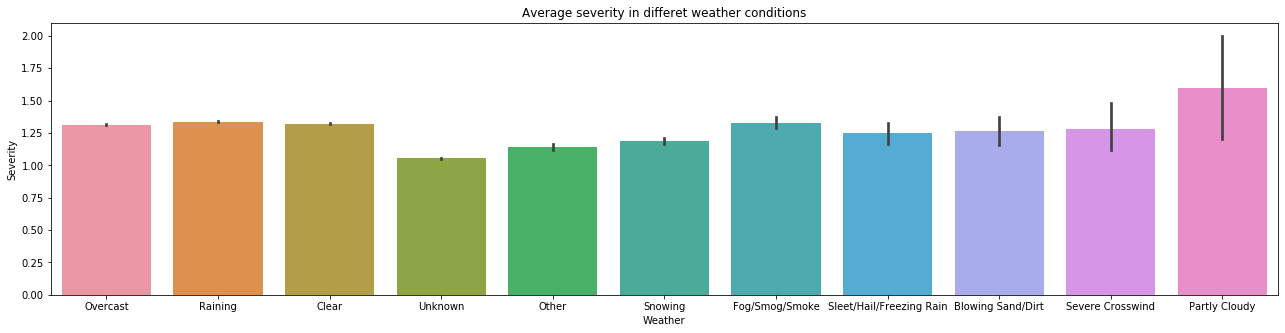

In [16]:
plt.figure(figsize=(22,5))
sns.barplot(x = "WEATHER", y = "SEVERITYCODE", data = df).set(title="Average severity in differet weather conditions", xlabel = "Weather", ylabel = "Severity")

## Features from the dataset. 
While the training data contains many interesting features, many of them are too optimistic to use for a prediction. For example, the number of vehicles involved is a very good predictor for severity, but we cannot know before the accident how many vehicles will be involved. As such, only factors that we can actually know beforehand will be used.

The following will be used to predict Severity: 
- ADDRTYPE, as intsersections might be more severe than just a tailend incident
- ROADCOND, since wheter weather makes it slippery
- LIGHTCOND, since low visibility impacts the ability to mitigate the severity
- WEATHER, probably correlated with road condition, but still could be useful
- INCDTTM, useful for feature engineering time of day and prevalence of accidents during months

### Data and preprocessing:
NaNs will be dropped. This will result in still a very large dataset, and avoids data cleaning issues, as well as issues with imputation affecting the results. 

In [5]:
df['INCDTTM'] = pd.to_datetime(df['INCDTTM'])
df['dayofweek'] = df['INCDTTM'].dt.dayofweek
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df = df[["SEVERITYCODE", "ADDRTYPE", "ROADCOND", "LIGHTCOND", "WEATHER", "dayofweek", "weekend"]]
df.dropna(inplace=True)
df.describe()

,SEVERITYCODE,dayofweek,weekend
count,187525.000000,187525.000000,187525.000000
mean,1.303336,2.944189,0.420728
std,0.459700,1.922827,0.493677
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000
50%,1.000000,3.000000,0.000000
75%,2.000000,5.000000,1.000000
max,2.000000,6.000000,1.000000


# Methodology
The data will first be engineered, so features are extracted, such as dummy variables for weekend, and the weekday.

It will then be split into a training set and a testing set. Since the data is unbalanced, it is stratified in the dependent variable. The following models will first be trained on the training set:
1. Random Forrest 
1. Support Vector Machine
1. Logistic Regression

Since this is a predictive classifier, these  models will be used. These perform well wit little to no hyperparameter tuning, and don't require much computing power.

In the trainining, a pipeline that one-hot encodes the categorical variables will be applied. 

This is then evaluated on a testing set that was set aside. 

In [6]:
X = df[["ADDRTYPE", "ROADCOND", "LIGHTCOND", "WEATHER", "dayofweek", "weekend"]]
Y = df[["SEVERITYCODE"]]
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 0, stratify = Y)
x_train.head()

,ADDRTYPE,ROADCOND,LIGHTCOND,WEATHER,dayofweek,weekend
51102,Block,Unknown,Unknown,Unknown,2,0
166511,Intersection,Dry,Daylight,Clear,0,0
64187,Block,Dry,Daylight,Clear,0,0
86393,Block,Dry,Daylight,Clear,2,0
5769,Block,Dry,Daylight,Overcast,4,1


In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

## Evaluation
From the testing set, the following evaluation metrics will be used:

#### All
- Accuracy, for how many of the classifications are correctly classified
- Jaccard similarity index, for a weighted accuracy score
- F1 score, for another score

These will then provide tiebreakers. If two models are the same in one score, they can break using another.

#### Just Logistic Regression
- Log Loss

Since Logistic Regression also can be measured using this, it will be provided as well, but since the others do not, it's mostly for transparency and if the Logistic Regression should be tied in all other metrics. 

### Preprocessing pipeline
All categorical will be one-hot encoded. 

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for categorical data
categorical_cols = ["ADDRTYPE","ROADCOND","LIGHTCOND","WEATHER"]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse = False))
])

forest = RandomForestClassifier()
rf_mod = Pipeline(steps=[('preprocessor', categorical_transformer),
                ('model', forest)
                ])


svm = SVC(gamma='auto')
svm_mod = Pipeline(steps=[('preprocessor', categorical_transformer),
                ('model', svm)
                ])

logreg = LogisticRegression()
logreg_mod = Pipeline(steps=[('preprocessor', categorical_transformer),
                ('model', logreg)
                ])


# Training

In [9]:
rf_mod.fit(x_train, y_train)
svm_mod.fit(x_train, y_train)
logreg_mod.fit(x_train, y_train)

/Users/leocarlsson/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/leocarlsson/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/Users/leocarlsson/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/leocarlsson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a sol

Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('onehot',
                                  OneHotEncoder(categorical_features=None,
                                                categories=None, drop=None,
                                                dtype=<class 'numpy.float64'>,
                                                handle_unknown='ignore',
                                                n_values=None, sparse=False))],
                          verbose=False)),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0

# Predicting values

In [12]:
yhat_rf = rf_mod.predict(x_test)
yhat_svm = svm_mod.predict(x_test)
yhat_logreg = logreg_mod.predict(x_test)
yhat_logreg_proba = logreg_mod.predict_proba(x_test)

# Evaluation on the test set

In [25]:
from sklearn.metrics import f1_score, jaccard_score, accuracy_score, log_loss

y_predictions=[yhat_rf, yhat_svm, yhat_logreg]

# with Accuracy
accuracy_scores = [round(accuracy_score(y_test, y_prediction), 3) for y_prediction in y_predictions]

# with Jaccard
jaccard_scores=[round(jaccard_score(y_test, y_prediction), 3) for y_prediction in y_predictions]

# with F1-score
F1_scores=[round(f1_score(y_test, y_prediction), 3) for y_prediction in y_predictions]

# with log-loss
logloss_scores=['NA', 'NA', round(log_loss(y_test, yhat_logreg_proba),3)]


In [26]:
Report=pd.DataFrame()
Report['Accuracy'] = accuracy_scores
Report['Jaccard']=jaccard_scores
Report['F1-score']=F1_scores
Report['LogLoss']=logloss_scores
Report.index=['Random Forest', 'SVM', 'Logistic Regression']
Report

,Accuracy,Jaccard,F1-score,LogLoss
Random Forest,0.695,0.694,0.819,NA
SVM,0.697,0.697,0.821,NA
LogisticRegression,0.696,0.696,0.821,0.58


# Results
From this it would appear that the SVM model is the best, since it performs best in terms of accuracy and Jaccard, but is tied with the Logistic Regression in terms of F1-score. 

# Discussion
It would seem like there still is a great deal of improvement in the models. From this, only around 70 % of accidents are correctly classified using the SVM-model.

Further improvement could be done in the following ways: 
- Hyperparameter tuning, as the SVM still has some parameters to tune, such as regularisation. The same can be said about the Random Forest, which also has tree dept to consider. This could be tuned using a grid search. 
- Feature engineering. Multiple new features could be extracted and used, and data from other places could be combined. For instance, the data contains dates and area coordinates. This could be connected to a weather database, and matched with the more precise weather that day and time. Then, better measurements in rainfall and so on could be used. 
- Better data. The data is still
- More data